### Введение.

Совместно с отделом маркетинга интернет-магазина, необходимо подготовить список гипотез для увеличения выручки. В частности, приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

Описание данных:

Таблица `hypothesis`:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

Таблица `orders`:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Таблица `visitors`:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

<a id="table_of_contents"></a>
#### Содержание:
* [Импорт библиотек и данных.](#step_0)
* [Часть 1. Приоритизация гипотез.](#step_1)
* [Часть 2. Анализ A/B-теста.](#step_2)
    * [2.1. График кумулятивной выручки по группам.](#step_2_1)
    * [2.2. График кумулятивного среднего чека по группам.](#step_2_2)
    * [2.3. График относительного изменения кумулятивного среднего чека группы B к группе A.](#step_2_3)
    * [2.4. График кумулятивной конверсии по группам.](#step_2_4)
    * [2.5. График относительного изменения кумулятивной конверсии группы B к группе A.](#step_2_5)
    * [2.6. Точечный график количества заказов по пользователям.](#step_2_6)
    * [2.7. Расчет 95-го и 99-го перцентилей количества заказов на пользователя. Определение границы для аномальных пользователей.](#step_2_7)
    * [2.8. Точечный график стоимостей заказов.](#step_2_8)
    * [2.9. Расчет 95-го и 99-го перцентилей стоимости заказов. Определение границы для аномальных заказов.](#step_2_9)
    * [2.10. Расчет статистической значимости различий в конверсии между группами по «сырым» данным.](#step_2_10)
    * [2.11. Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.](#step_2_11)
    * [2.12. Расчет статистической значимости различий в конверсии между группами по «очищенным» данным.](#step_2_12)
    * [2.13. Расчет статистической значимости  различий в среднем чеке заказа между группами по «очищенным» данным.](#step_2_13)
    * [2.14. График кумулятивной выручки по группам по очищенным данным.](#step_2_14)
    * [2.15. График кумулятивного среднего чека по группам по очищенным данным.](#step_2_15)
    * [2.16. График кумулятивной конверсии по группам по очищенным данным.](#step_2_16)
* [Итог.](#step_total)

<a id="step_0"></a>
### Импорт библиотек и данных.
[К содержанию](#table_of_contents)

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import warnings
import requests
from io import BytesIO

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [2]:
# функция чтения данных из google sheets
def data_from_g_sheets(spreadsheet_id):
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    return pd.read_csv(BytesIO(r.content))

In [3]:
try:
    
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
    
except:
    
    hypothesis = data_from_g_sheets('1YDcZZoEkRxRMUfMwGJB1iXTV6yZ7o5EuvTpL0lDkOUM')
    orders = data_from_g_sheets('1F5B4YJC8R9nfu0k1Nm-_yWOcpk81olcFMh7dsRpLx7Y')
    visitors = data_from_g_sheets('1UN1iAiJUOxnDTdBvJeUL5E3-xnGgzeGagva2aUxQ9j8')

<a id = "step_1"></a>
### Часть 1. Приоритизация гипотез.
[К содержанию](#table_of_contents)

In [4]:
display(hypothesis.info())
display(hypothesis)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Замена верхнего регистра на нижний в названиях столбцов таблицы `hypothesis`:

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()

Добавление слолбца `ICE` с расчитанным методом приоретизации `impact, confidence, effort / ease` для `hypothesis`:

In [6]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
display(hypothesis[['hypothesis', 'ICE']].sort_values('ICE', ascending = False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Добавление слолбца `RICE` с расчитанным методом приоретизации `reach, impact, confidence / effort` для `hypothesis`:

In [7]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE']].sort_values('RICE', ascending = False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


#### Часть 1. Приоритизация гипотез. Вывод. 

Наиболее приоритетными гипотезами после применения фреймворка ICE являются гипотезы:
- `№8` - Запустить акцию, дающую скидку на товар в день рождения;
- `№0` - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- `№7` - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- `№6` - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Наиболее приоритетными гипотезами после применения фреймворка RICE являются гипотезы:
- `№7` - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- `№2` - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- `№0` - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- `№6` - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

При сопоставлении результатов `ICE` и `RICE` можно отметить, что в первую очередь стоит проверть гипотезы: `№0`, `№7` и `№6`. Гипотезы `№2` и `№8` взаимно отсутствуют в `ICE` и `RICE`

<a id = "step_2"></a>
### Часть 2. Анализ A/B-теста.
[К содержанию](#table_of_contents)

##### Таблица `orders`. Изучение общей информации о данных. Подготовка данных.

In [8]:
display(orders.info())
display(orders.head())
print('Количество дубликатов в таблице orders:', orders.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Количество дубликатов в таблице orders: 0


In [9]:
#изменение типа данных столбца date на to_datetime
orders['date'] = pd.to_datetime(orders['date'])

##### Таблица `visitors`. Изучение общей информации о данных. Подготовка данных.

In [10]:
display(visitors.info())
display(visitors.head())
print('Количество дубликатов в таблице orders:', visitors.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Количество дубликатов в таблице orders: 0


In [11]:
visitors['date'] = pd.to_datetime(visitors['date'])

<a id = "step_2_1"></a>
##### 2.1. График кумулятивной выручки по группам.
[К содержанию](#table_of_contents)

In [12]:
datesGroups = orders[['date', 'group']].drop_duplicates()

In [13]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])].agg({
                                         'date' : 'max', 
                                         'group' : 'max',
                                         'transactionId' : pd.Series.nunique,
                                         'visitorId' : pd.Series.nunique,
                                         'revenue' : 'sum'}), axis = 1).sort_values(by = ['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: 
                                       visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                               visitors['group'] == x['group'])].agg({
                                           'date' : 'max', 
                                           'group' : 'max', 
                                           'visitors' : 'sum'}), axis = 1).sort_values(by = ['date','group'])

In [14]:
cumulativeData = pd.merge(ordersAggregated, visitorsAggregated, left_on = ['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

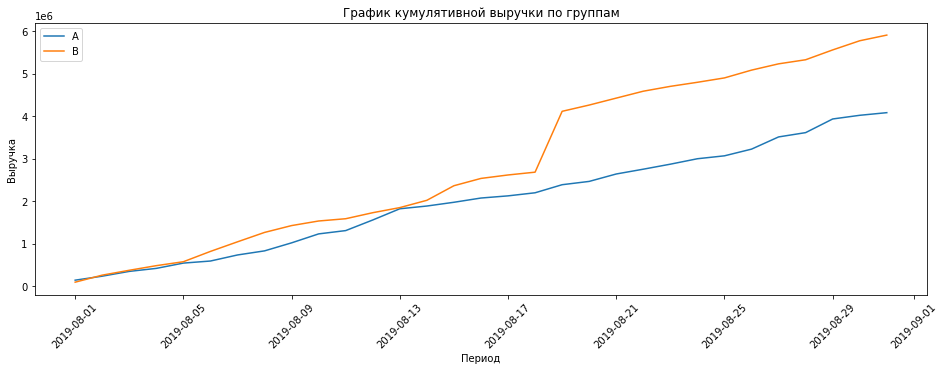

In [15]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date','revenue', 'orders']]

plt.figure(figsize = (16, 5))
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Выручка')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'B')
plt.legend()
plt.show()

##### 2.1. Вывод.
В соответствии с графиком кумулятивной выручки по группам, можно сделать вывод, что в середине теста, сегмент `B` вырвался вперед и до конца теста остается лидиром. Так же стоит обратить внимание на резкий скачок сегмента `B`. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

<a id = "step_2_2"></a>
##### 2.2. График кумулятивного среднего чека по группам.
[К содержанию](#table_of_contents)

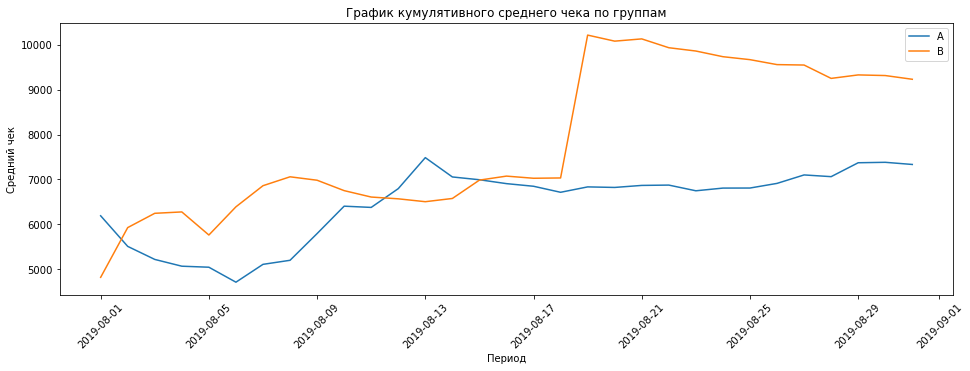

In [16]:
plt.figure(figsize = (16, 5))
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Средний чек')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'] / cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'] / cumulativeRevenueB['orders'], label = 'B')
plt.legend()
plt.show()

##### 2.2. Вывод.
График кумулятивного среднего чека по группам сильно колеблется, но ближе к концу теста стабилизируется. Так же стоит обратить внимание на резкий скачок сегмента `B`.

<a id = "step_2_3"></a>
##### 2.3. График относительного изменения кумулятивного среднего чека группы B к группе A.
[К содержанию](#table_of_contents)

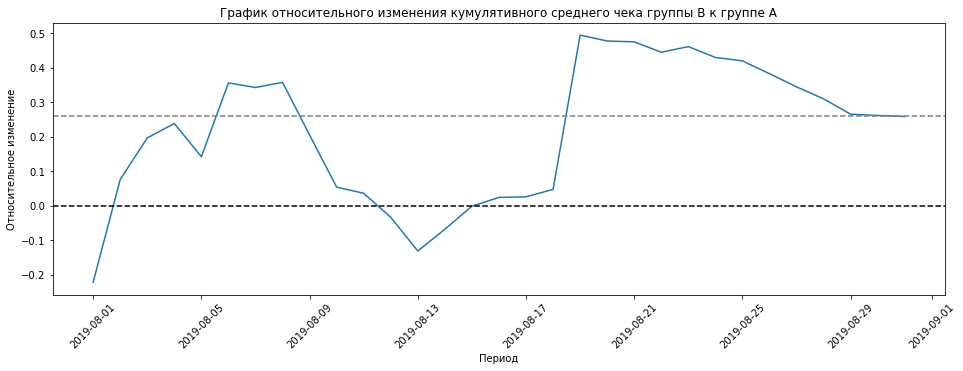

In [17]:
mergedCumulativeRevenue = pd.merge(cumulativeRevenueA, cumulativeRevenueB, 
                                   left_on = 'date', right_on = 'date', how = 'left', suffixes = ['A', 'B'])
#print(mergedCumulativeRevenue)

plt.figure(figsize = (16, 5))
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Относительное изменение')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB'] / mergedCumulativeRevenue['ordersB']) / 
         (mergedCumulativeRevenue['revenueA'] / mergedCumulativeRevenue['ordersA']) - 1)
plt.axhline(y = 0, color = 'black', linestyle = '--') 
plt.axhline(y = 0.26, color = 'grey', linestyle = '--')
plt.show()

##### 2.3. Вывод.
Из графика относительного изменения кумулятивного среднего чека группы `B` к группе `A` видно, что в некоторые даты, результаты теста сильно и резко менялись. Возможно, это связанно с номальными заказами. Так же, к концу теста группа `B` возможно стабилизировалась в районе 26%.

<a id = "step_2_4"></a>
##### 2.4. График кумулятивной конверсии по группам.
[К содержанию](#table_of_contents)

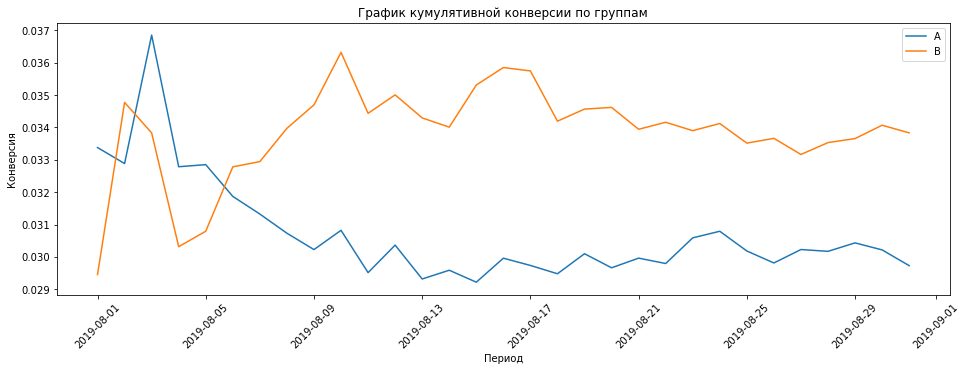

In [18]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize = (16, 5))
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Конверсия')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.show()

##### 2.4. Вывод.
В самом начале теста, сегмент `A` имел бОльшую конверсию, но вскоре сегмент `B` вырвался вперед и стабильно зафиксировался. Колебания графика в начале теста возможно говорят о еще не достаточном количестве данных.

<a id = "step_2_5"></a>
##### 2.5. График относительного изменения кумулятивной конверсии группы B к группе A.
[К содержанию](#table_of_contents)

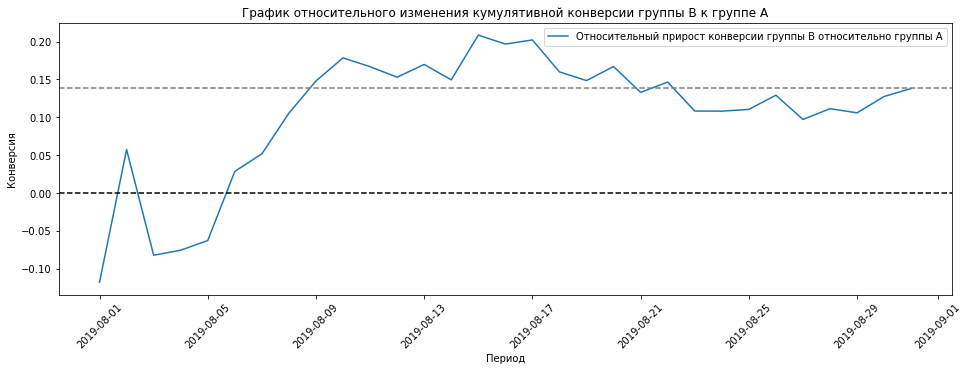

In [19]:
mergedCumulativeConversions = pd.merge(cumulativeDataA[['date','conversion']], 
                                       cumulativeDataB[['date','conversion']], left_on = 'date', right_on = 'date', 
                                       how = 'left', suffixes = ['A', 'B'])

plt.figure(figsize = (16, 5))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Конверсия')
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB'] / 
         mergedCumulativeConversions['conversionA']-1, label = "Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.139, color = 'grey', linestyle = '--')
plt.show()

##### 2.5. Вывод.
Из графика относительного изменения кумулятивной конверсии группы `B` к группе `A` видно, что практически с самого начала теста, группа `B` лидирует по конверсии. И к концу теста либо стабилизировалась в районе 14%, либо продолжает увеличиваться.

<a id = "step_2_6"></a>
##### 2.6. Точечный график количества заказов по пользователям.
[К содержанию](#table_of_contents)

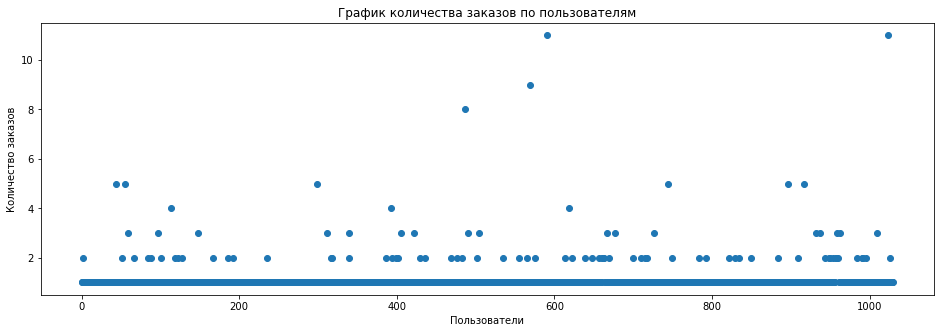

In [20]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], 
                          axis = 1).groupby('visitorId', as_index = False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['userId','orders']

plt.figure(figsize = (16, 5))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('График количества заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

##### 2.6. Вывод.
В соответствии с точечным графиком количества заказов по пользователям, можно сделать вывод, что посетителей, сделавших не более 1-го заказа большинство.

<a id = "step_2_7"></a>
##### 2.7. Расчет 95-го и 99-го перцентилей количества заказов на пользователя. Определение границы для аномальных пользователей.
[К содержанию](#table_of_contents)

In [21]:
print('Значение 95-го перцентиля количества заказов на пользователя:', np.percentile(ordersByUsers['orders'], [95]))
print('Значение 99-го перцентиля количества заказов на пользователя:', np.percentile(ordersByUsers['orders'], [99]))

Значение 95-го перцентиля количества заказов на пользователя: [2.]
Значение 99-го перцентиля количества заказов на пользователя: [4.]


##### 2.7. Вывод.
Не более 5% всех посетителей сделало больше 2х заказов, и не более 1% всех посетителей сделало больше 4х заказов.
Границу для аномальных пользователей определим в 95%, то есть пользователи, совершившие более 2х заказов - не попадут в очищенные данные.

<a id = "step_2_8"></a>
##### 2.8. Точечный график стоимостей заказов.
[К содержанию](#table_of_contents)

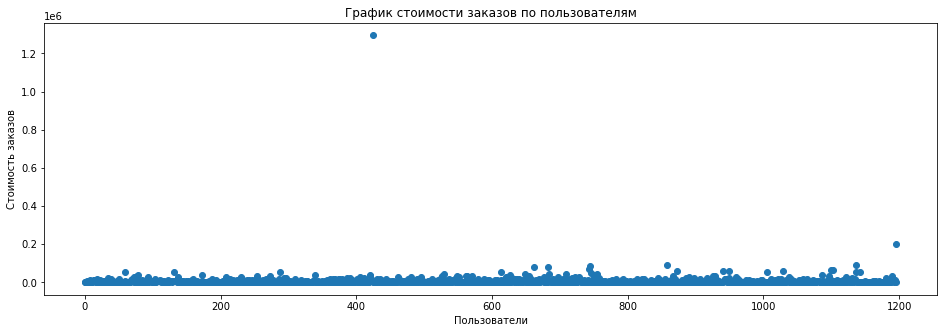

In [22]:
#print(orders.sort_values(by = 'revenue', ascending = False).head(10))
#display(orders['revenue'].describe().round())
plt.figure(figsize = (16, 5))
plt.title('График стоимости заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказов')
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.show()

##### 2.8. Вывод.
Из графика стоимости заказов по пользователям видно, что есть сильные выбросы.

<a id = "step_2_9"></a>
##### 2.9. Расчет 95-го и 99-го перцентилей стоимости заказов. Определение границы для аномальных заказов.
[К содержанию](#table_of_contents)

In [23]:
print('Значение 95-го перцентиля стоимости заказов:', np.percentile(orders['revenue'], [95]))
print('Значение 99-го перцентиля стоимости заказов:', np.percentile(orders['revenue'], [99]))

Значение 95-го перцентиля стоимости заказов: [28000.]
Значение 99-го перцентиля стоимости заказов: [58233.2]


##### 2.9. Вывод.
Стоимость не более 5% всех заказов больше 28000, и стоимость не более 1% всех заказов больше 58233. Границу для аномальных заказов определим в 95%, то есть заказы, стоимость которых больше чем 28000 - не попадут в очищенные данные.

<a id = "step_2_10"></a>
##### 2.10. Расчет статистической значимости различий в конверсии между группами по «сырым» данным.
[К содержанию](#table_of_contents)

Сформулируем гипотезы:

- H0: Конверсия группы `A` равна конверсии группы `B`
- H1: Конверсия группы `A` не равна конверсии группы `B`

In [24]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis = 1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [25]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis = 1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [26]:
ordersADaily = orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]\
                                            .groupby('date', as_index = False)\
                                            .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
                                            .agg({'date' : 'max', 'ordersPerDateA' : 'sum', 'revenuePerDateA' : 'sum'}), axis = 1)\
                                            .sort_values(by = ['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [27]:
ordersBDaily = orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]\
                                            .groupby('date', as_index = False)\
                                            .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]\
                                            .agg({'date' : 'max', 'ordersPerDateB' : 'sum', 'revenuePerDateB' : 'sum'}), axis = 1)\
                                            .sort_values(by = ['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [28]:
data = pd.merge(ordersADaily, ordersBDaily, left_on = 'date', right_on = 'date', how = 'left')\
                                            .merge(ordersACummulative, left_on = 'date', right_on = 'date', how ='left')\
                                            .merge(ordersBCummulative, left_on = 'date', right_on = 'date', how = 'left')\
                                            .merge(visitorsADaily, left_on = 'date', right_on = 'date', how = 'left')\
                                            .merge(visitorsBDaily, left_on = 'date', right_on = 'date', how = 'left')\
                                            .merge(visitorsACummulative, left_on = 'date', right_on = 'date', how = 'left')\
                                            .merge(visitorsBCummulative, left_on = 'date', right_on = 'date', how = 'left')
#display(data.head(10))

In [29]:
ordersByUsersA = orders[orders['group'] == 'A'].groupby('visitorId', as_index = False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group'] == 'B'].groupby('visitorId', as_index = False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index = np.arange(data['visitorsPerDateA'].sum()\
                                            - len(ordersByUsersA['orders'])), name = 'orders')], axis = 0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index = np.arange(data['visitorsPerDateB'].sum()\
                                            - len(ordersByUsersB['orders'])), name = 'orders')], axis = 0) 

print('Cтатистическая значимость (p-value) различий в конверсии между группами: {0:.4f}'\
                                            .format(stats.mannwhitneyu(sampleA, sampleB)[1]))

if (stats.mannwhitneyu(sampleA, sampleB)[1] < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('Относительное различие в конверсии между группами: {0:.3f}'.format((data['ordersPerDateB'].sum()\
                                            / data['visitorsPerDateB'].sum()) / (data['ordersPerDateA'].sum()\
                                            / data['visitorsPerDateA'].sum()) - 1))

Cтатистическая значимость (p-value) различий в конверсии между группами: 0.0084
Отвергаем нулевую гипотезу
Относительное различие в конверсии между группами: 0.138


##### 2.10. Вывод.
Так как p-value меньше 0.05, можно сказать, что в конверсии между группами по "сырым" данным есть статистически значимые различия. Относительный прирост конверсии группы `B` к конверсии группы `A` составляет 13.8%

<a id = "step_2_11"></a>
##### 2.11. Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.
[К содержанию](#table_of_contents)

Сформулируем гипотезы:

- H0: Средний чек заказа группы `A` равен среднему чеку заказа группы `B`
- H1: Средний чек заказа группы `A` не равен среднему чеку заказа группы `B`

In [30]:
print('Cтатистическая значимость (p-value) различий в среднем чеке заказа между группами: {0:.4f}'\
                                            .format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))

if ((stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]) < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

#print(orders[orders['group'] == 'B']['revenue'].mean())
#print(orders[orders['group'] == 'A']['revenue'].mean())

print('Относительный прирост среднего чека группы B: {0:.3f}'.format(orders[orders['group'] == 'B']['revenue'].mean()\
                                            / orders[orders['group'] == 'A']['revenue'].mean() - 1)) 

Cтатистическая значимость (p-value) различий в среднем чеке заказа между группами: 0.3646
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека группы B: 0.259


##### 2.11. Вывод.
Так как p-value больше 0.05, можно сказать, что статистически значимых различий по "сырым" данным между группами `A` и `B` нет.

<a id = "step_2_12"></a>
##### 2.12. Расчет статистической значимости различий в конверсии между группами по «очищенным» данным.
[К содержанию](#table_of_contents)

Сформулируем гипотезы:

- H0: Конверсия группы `A` равна конверсии группы `B`
- H1: Конверсия группы `A` не равна конверсии группы `B`

In [31]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],\
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index = np.arange(data['visitorsPerDateA'].sum()\
                                - len(ordersByUsersA['orders'])),name = 'orders')], axis = 0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], 
                             pd.Series(0, index = np.arange(data['visitorsPerDateB'].sum()\
                                - len(ordersByUsersB['orders'])),name = 'orders')], axis = 0) 

print('Cтатистическая значимость (p-value) различий в конверсии между группами: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

if (stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

print('Относительный прирост конверсии очищенной группы B: {0:.3f}'.format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

Cтатистическая значимость (p-value) различий в конверсии между группами: 0.00652
Отвергаем нулевую гипотезу
Относительный прирост конверсии очищенной группы B: 0.173


##### 2.12. Вывод.
Так как p-value меньше 0.05, можно сказать, что в конверсии между группами по "очищенным" данным есть статистически значимые различия. Относительный прирост конверсии группы `B` к конверсии группы `A` составляет 17.3%

<a id = "step_2_13"></a>
##### 2.13. Расчет статистической значимости  различий в среднем чеке заказа между группами по «очищенным» данным.
[К содержанию](#table_of_contents)

Сформулируем гипотезы:

- H0: Средний чек заказа группы `A` равен среднему чеку заказа группы `B`
- H1: Средний чек заказа группы `A` не равен среднему чеку заказа группы `B`

In [32]:
result = stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group'] == 'B',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]


print('Cтатистическая значимость (p-value) различий в среднем чеке заказа между группами: {0:.3f}'.format(result))

if (result < 0.05):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


print('Относительный прирост среднего чека очищенной группы B: {0:.3f}'.format(
    orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() /
    orders[np.logical_and(
        orders['group'] == 'A',
        np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1)) 

Cтатистическая значимость (p-value) различий в среднем чеке заказа между группами: 0.369
Не получилось отвергнуть нулевую гипотезу
Относительный прирост среднего чека очищенной группы B: -0.020


In [33]:
orders_clear = orders.query('revenue <= 28000')

In [34]:
orders_clear[orders_clear['group']=='A']['revenue'].mean()

5213.212806026366

In [35]:
orders_clear[orders_clear['group']=='B']['revenue'].mean()

5128.66501650165

##### 2.13. Вывод.
Так как p-value больше 0.05, можно сказать, что статистически значимых различий по "очищенным" данным между группами `A` и `B` нет.

In [36]:
orders_clear = orders[~orders['visitorId'].isin(abnormalUsers)]
datesGroups_clear = orders_clear[['date', 'group']].drop_duplicates()

In [37]:
ordersAggregated_clear = datesGroups_clear.apply(lambda x: orders_clear[np.logical_and(orders_clear['date'] <= x['date'], 
                                                                     orders_clear['group'] == x['group'])].agg({
                                         'date' : 'max', 
                                         'group' : 'max',
                                         'transactionId' : pd.Series.nunique,
                                         'visitorId' : pd.Series.nunique,
                                         'revenue' : 'sum'}), axis = 1).sort_values(by = ['date','group'])

visitorsAggregated_clear = datesGroups_clear.apply(lambda x: 
                                       visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                               visitors['group'] == x['group'])].agg({
                                           'date' : 'max', 
                                           'group' : 'max', 
                                           'visitors' : 'sum'}), axis = 1).sort_values(by = ['date','group'])

In [38]:
cumulativeData_clear = pd.merge(ordersAggregated_clear, visitorsAggregated_clear, left_on = ['date', 'group'], right_on=['date', 'group'])
cumulativeData_clear.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

<a id = "step_2_14"></a>
##### 2.14. График кумулятивной выручки по группам по очищенным данным.
[К содержанию](#table_of_contents)

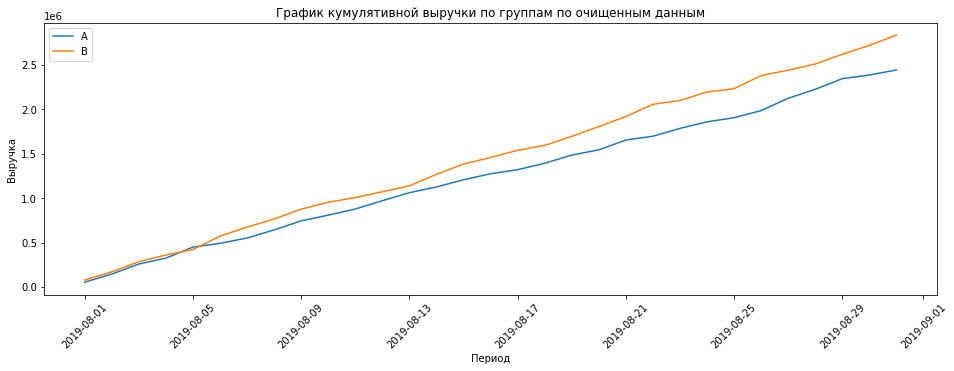

In [39]:
cumulativeRevenueA_clear = cumulativeData_clear[cumulativeData_clear['group'] == 'A'][['date','revenue', 'orders']]
cumulativeRevenueB_clear = cumulativeData_clear[cumulativeData_clear['group'] == 'B'][['date','revenue', 'orders']]

plt.figure(figsize = (16, 5))
plt.title('График кумулятивной выручки по группам по очищенным данным')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Выручка')
plt.plot(cumulativeRevenueA_clear['date'], cumulativeRevenueA_clear['revenue'], label = 'A')
plt.plot(cumulativeRevenueB_clear['date'], cumulativeRevenueB_clear['revenue'], label = 'B')
plt.legend()
plt.show()

<a id = "step_2_15"></a>
##### 2.15. График кумулятивного среднего чека по группам по очищенным данным.
[К содержанию](#table_of_contents)

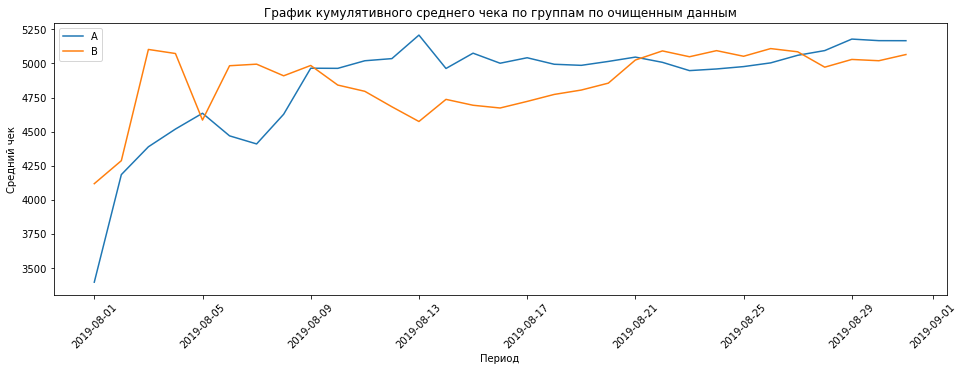

In [40]:
plt.figure(figsize = (16, 5))
plt.title('График кумулятивного среднего чека по группам по очищенным данным')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Средний чек')
plt.plot(cumulativeRevenueA_clear['date'], cumulativeRevenueA_clear['revenue'] / cumulativeRevenueA_clear['orders'], label = 'A')
plt.plot(cumulativeRevenueB_clear['date'], cumulativeRevenueB_clear['revenue'] / cumulativeRevenueB_clear['orders'], label = 'B')
plt.legend()
plt.show()

<a id = "step_2_16"></a>
##### 2.16. График кумулятивной конверсии по группам по очищенным данным.
[К содержанию](#table_of_contents)

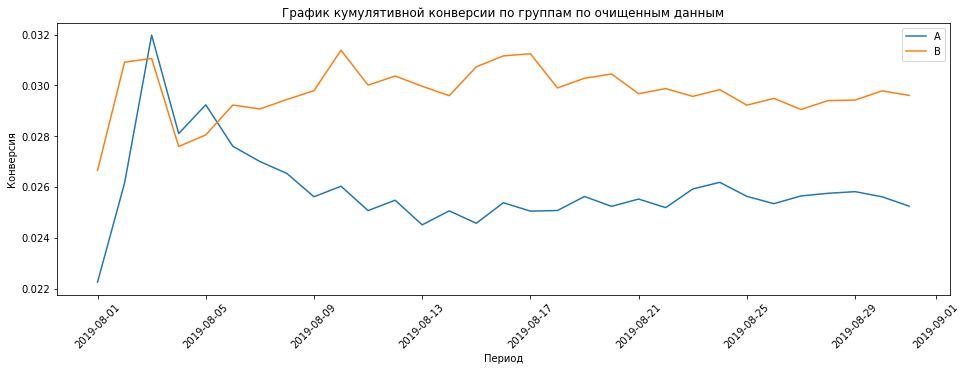

In [41]:
cumulativeData_clear['conversion'] = cumulativeData_clear['orders']/cumulativeData_clear['visitors']

# данные по группе A
cumulativeDataA_clear = cumulativeData_clear[cumulativeData_clear['group']=='A']

# данные по группе B
cumulativeDataB_clear = cumulativeData_clear[cumulativeData_clear['group']=='B']

plt.figure(figsize = (16, 5))
plt.title('График кумулятивной конверсии по группам по очищенным данным')
plt.xlabel('Период')
plt.xticks(rotation = 45) 
plt.ylabel('Конверсия')
plt.plot(cumulativeDataA_clear['date'], cumulativeDataA_clear['conversion'], label='A')
plt.plot(cumulativeDataB_clear['date'], cumulativeDataB_clear['conversion'], label='B')
plt.legend()
plt.show()

<a id = "step_total"></a>
### Итог.
[К содержанию](#table_of_contents)

Наиболее приоритетными гипотезами после применения фреймворка ICE являются гипотезы:
- `№8` - Запустить акцию, дающую скидку на товар в день рождения;
- `№0` - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- `№7` - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- `№6` - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

Наиболее приоритетными гипотезами после применения фреймворка RICE являются гипотезы:
- `№7` - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- `№2` - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- `№0` - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- `№6` - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

При сопоставлении результатов `ICE` и `RICE` можно отметить, что в первую очередь стоит проверть гипотезы: `№0`, `№7` и `№6`. 

На «сырых» данных обнаружен резкий скачок кумулятивного среднего чека и кумулятивной выручки сегмента B, на который стоит обратить внимание. 

Имеющиеся факты:
- Есть статистически значимое различие по конверсии между группами как по «сырым» данным, так и после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами по «сырым» сообщает, что результаты группы `B` лучше группы `A`. Группа `B` к концу теста либо стабилизировалась в районе 14%, либо продолжает увеличиваться;

Стоит отметить, что в соотсетствии с графиком кумулятивной выручки по группам как по «сырым» данным, так и после фильтрации, группа `B` выглядит лучше группы `A`. Однако, в соответствии с графиком кумулятивного среднего чека по группам, после фильтрации данных, группа `B` занимает худшую позицию относительно группы `A`. Так же, данный график по очищенным данным подтверждает отсутствие статистически значимого различия по среднему чеку между группами `A` и `B`. Кумулятивная конверсия по группам, как до, так и после фильтрации данных принципиально не изменилась: результаты группы `B` лучше результатов группы `A`.

Вывод:

Несмотря на то, что группа `B` по некоторым параметрам выглядит выгоднее группы `A`, тем не менее есть аргументы, которые не позволяют однозначно заявить о победе группы `B`. Так как перспектива у группы `B` есть, возможно, стоит продолжить тест, собрать больше данных для выяснения ситуации.